In [1]:
from IPython.core.display import HTML
display(HTML('<style>.container { width:95% !important; } </style>'))

%load_ext autoreload
%autoreload 2

In [2]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from stochastic_betting import *

sns.set()
pd.options.display.max_columns = None

# Setup a biased coin
$(p_{coin}, 1-p_{coin})$ denotes the probabilities of the various outcomes.

In [3]:
coin = Coin(p=0.7)

seed = 42

# Random vs Bellman betting

* Random($p$): bet on a direction with probability $p$, the other with probability $p$, the size of the bet at each round is a fixed fraction of the current fortune;

* ExactBellman($p$): bet on the direction with highest probability, the size of the bet at each round is a fraction $u$ of current fortune $M$ such that
$$
u \in \arg \max_{0\leq u\leq M} \mathbb{E}[\log(M + u\epsilon)],
$$
where $\epsilon$ is a random variable with values +/- 1 depending on whether the bet is successful. This strategy has the following expected growth rate:
$$
\mathbb{E}[\log \frac{V_T}{V_0}] = \alpha T
$$
where $(V_t)_{t\in\mathbb{N}}$ is the wealth process and $\alpha = \log(2) - Entropy(\epsilon)$.

* EmpiricalBellman: same as ExactBellman, but instead of assuming $p$ is known, it is estimated on-the-fly (empirical average of the observed coin outcomes).

In [4]:
bet_random = RandomBet(coin, init_fortune=100, p=0.7, unit_bet=0.1, bet_style='fractional', seed=seed)

bet_exact_bellman = ExactBellmanBet(coin, init_fortune=100, p=0.7, seed=seed)

warmup_time = 20
bet_empirical_bellman = EmpiricalBellmanBet(coin, init_fortune=100, warmup_time=warmup_time, seed=seed)

rule = lambda p: (p - 0.5) * (p + 1)
bet_exact_quadratic = ExactArbitraryBet(coin, init_fortune=100, p=0.7, rule=rule, seed=seed)
bet_empirical_quadratic = EmpiricalArbitraryBet(coin, init_fortune=100, warmup_time=warmup_time, rule=rule, seed=seed)

N = 1000
results_random = bet_random.simulate(N)
results_exact_bellman = bet_exact_bellman.simulate(N)
results_empirical_bellman = bet_empirical_bellman.simulate(N)
results_exact_quadratic = bet_exact_quadratic.simulate(N)
results_empirical_quadratic = bet_empirical_quadratic.simulate(N)

alpha = np.log(2) - coin.entropy

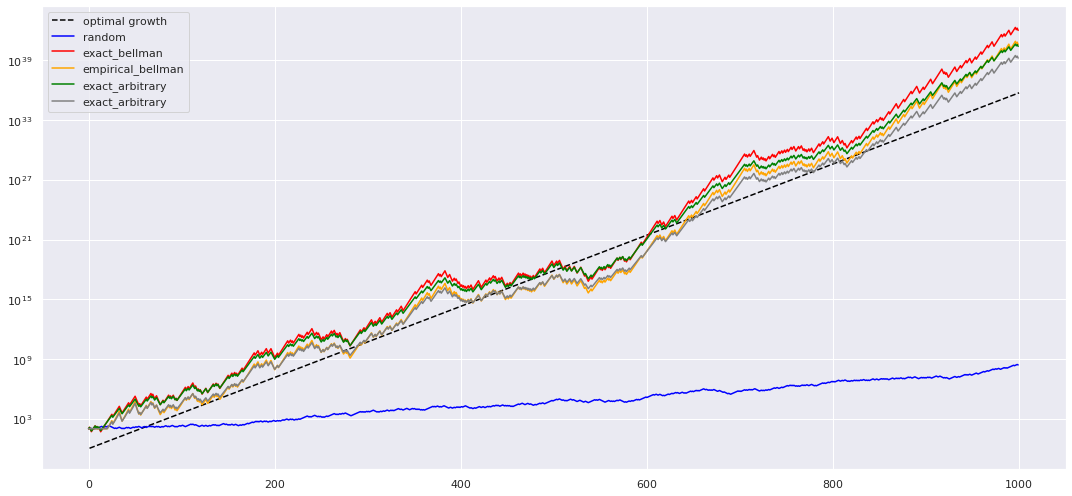

In [5]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(15, 7), nrows=1, ncols=1)
    
    ax.plot(np.linspace(1, N, N), np.exp(alpha * np.linspace(1, N, N)), color='black', linestyle='dashed', label='optimal growth')
    results_random['fortune'].plot(ax=ax, color='blue', label='random', logy=True)
    results_exact_bellman['fortune'].plot(ax=ax, color='red', label='exact_bellman', logy=True)
    results_empirical_bellman['fortune'].plot(ax=ax, color='orange', label='empirical_bellman', logy=True)
    results_exact_quadratic['fortune'].plot(ax=ax, color='green', label='exact_arbitrary', logy=True)
    results_empirical_quadratic['fortune'].plot(ax=ax, color='grey', label='exact_arbitrary', logy=True)

    ax.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

# Empirically check that the Bellman criterion maximizes the log utility of the terminal fortune

(Empirical and Exact have similar performance after one discounts the advantage of Exact which starts earlier i.e Empirical has less time to accumulate profit because of the warmup period).

In [ ]:
n_sim = 100
N = 100

log_fortune_random = np.empty(n_sim)
log_fortune_exact_bellman = np.empty(n_sim)
log_fortune_empirical_bellman = np.empty(n_sim)
log_fortune_exact_quadratic = np.empty(n_sim)
log_fortune_empirical_quadratic = np.empty(n_sim)

for i in tqdm(range(n_sim)):
    results_random = bet_random.simulate(N)
    results_exact_bellman = bet_exact_bellman.simulate(N)
    results_empirical_bellman = bet_empirical_bellman.simulate(N)
    results_exact_quadratic = bet_exact_quadratic.simulate(N)
    results_empirical_quadratic = bet_empirical_quadratic.simulate(N)
    
    log_fortune_random[i] = np.log(results_random['fortune'].iloc[-1] / results_random['fortune'].iloc[0] / N)
    log_fortune_exact_bellman[i] = np.log(results_exact_bellman['fortune'].iloc[-1] / results_exact_bellman['fortune'].iloc[0] / N)
    log_fortune_empirical_bellman[i] = np.log(results_empirical_bellman['fortune'].iloc[-1] / results_empirical_bellman['fortune'].iloc[warmup_time] / (N - warmup_time))
    log_fortune_exact_quadratic[i] = np.log(results_exact_quadratic['fortune'].iloc[-1] / results_exact_quadratic['fortune'].iloc[0] / N)
    log_fortune_empirical_quadratic[i] = np.log(results_empirical_quadratic['fortune'].iloc[-1] / results_empirical_quadratic['fortune'].iloc[warmup_time] / (N - warmup_time))

print(
    '--- Expected log fortune: ---\nRandom: {:.2f}\nExact Bellman: {:.2f}\nEmpirical Bellman: {:.2f}\nExact Quadratic: {:.2f}\nEmpirical Quadratic: {:.2f}'.format(
        log_fortune_random.mean(),
        log_fortune_exact_bellman.mean(),
        log_fortune_empirical_bellman.mean(),
        log_fortune_exact_quadratic.mean(),
        log_fortune_empirical_quadratic.mean(),
    )
)

# Random vs Bellman betting with mispecified parameter : right direction but wrong probablity

i.e parameter $p$ in the betting strategy is > $p_{coin} > \frac{1}{2}$.

Bellman still performs well but not optimally (does not maximize the log-utility).

In [ ]:
bet_random = RandomBet(coin, init_fortune=100, p=0.8, unit_bet=0.1, bet_style='fractional')
bet_exact_bellman = ExactBellmanBet(coin, init_fortune=100, p=0.8)
bet_empirical_bellman = EmpiricalBellmanBet(coin, init_fortune=100, warmup_time=warmup_time)

N = 1000
results_random = bet_random.simulate(N)
results_exact_bellman = bet_exact_bellman.simulate(N)
results_empirical_bellman = bet_empirical_bellman.simulate(N)

alpha = np.log(2) - coin.entropy

In [ ]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(15, 7), nrows=1, ncols=1)
    
    ax.plot(np.linspace(1, N, N), np.exp(alpha * np.linspace(1, N, N)), color='black', linestyle='dashed', label='optimal growth')
    results_random['fortune'].plot(ax=ax, color='blue', label='random', logy=True)
    results_exact_bellman['fortune'].plot(ax=ax, color='red', label='exact_bellman', logy=True)
    results_empirical_bellman['fortune'].plot(ax=ax, color='orange', label='empirical_bellman', logy=True)

    ax.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

In [ ]:
n_sim = 100
N = 100

log_fortune_random = np.empty(n_sim)
log_fortune_exact_bellman = np.empty(n_sim)
log_fortune_empirical_bellman = np.empty(n_sim)

for i in tqdm(range(n_sim)):
    results_random = bet_random.simulate(N)
    results_exact_bellman = bet_exact_bellman.simulate(N)
    results_empirical_bellman = bet_empirical_bellman.simulate(N)
    log_fortune_random[i] = np.log(results_random['fortune'].iloc[-1] / results_random['fortune'].iloc[0] / N)
    log_fortune_exact_bellman[i] = np.log(results_exact_bellman['fortune'].iloc[-1] / results_exact_bellman['fortune'].iloc[0] / N)
    log_fortune_empirical_bellman[i] = np.log(results_empirical_bellman['fortune'].iloc[-1] / results_empirical_bellman['fortune'].iloc[warmup_time] / (N - warmup_time))

print(
    '--- Expected log fortune: ---\nRandom: {:.2f}\nExact Bellman: {:.2f}\nEmpirical Bellman: {:.2f}'.format(
        log_fortune_random.mean(),
        log_fortune_exact_bellman.mean(),
        log_fortune_empirical_bellman.mean(),
    )
)

# Random vs Bellman betting with mispecified parameter : wrong direction

i.e parameter $p$ in the betting strategy is < $\frac{1}{2}$ while $p_{coin} > \frac{1}{2}$.

Bellman now completely underperforms.

In [ ]:
bet_random = RandomBet(coin, init_fortune=100, p=0.49, unit_bet=0.1, bet_style='fractional')
bet_exact_bellman = ExactBellmanBet(coin, init_fortune=100, p=0.49)
bet_empirical_bellman = EmpiricalBellmanBet(coin, init_fortune=100, warmup_time=warmup_time)

N = 1000
results_random = bet_random.simulate(N)
results_exact_bellman = bet_exact_bellman.simulate(N)
results_empirical_bellman = bet_empirical_bellman.simulate(N)

alpha = np.log(2) - coin.entropy

In [ ]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(15, 7), nrows=1, ncols=1)
    
    ax.plot(np.linspace(1, N, N), np.exp(alpha * np.linspace(1, N, N)), color='black', linestyle='dashed', label='optimal growth')
    results_random['fortune'].plot(ax=ax, color='blue', label='random', logy=True)
    results_exact_bellman['fortune'].plot(ax=ax, color='red', label='exact_bellman', logy=True)
    results_empirical_bellman['fortune'].plot(ax=ax, color='orange', label='empirical_bellman', logy=True)

    ax.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

In [ ]:
n_sim = 100
N = 100

log_fortune_random = np.empty(n_sim)
log_fortune_exact_bellman = np.empty(n_sim)
log_fortune_empirical_bellman = np.empty(n_sim)

for i in tqdm(range(n_sim)):
    results_random = bet_random.simulate(N)
    results_exact_bellman = bet_exact_bellman.simulate(N)
    results_empirical_bellman = bet_empirical_bellman.simulate(N)
    log_fortune_random[i] = np.log(results_random['fortune'].iloc[-1] / results_random['fortune'].iloc[0] / N)
    log_fortune_exact_bellman[i] = np.log(results_exact_bellman['fortune'].iloc[-1] / results_exact_bellman['fortune'].iloc[0] / N)
    log_fortune_empirical_bellman[i] = np.log(results_empirical_bellman['fortune'].iloc[-1] / results_empirical_bellman['fortune'].iloc[warmup_time] / (N - warmup_time))

print(
    '--- Expected log fortune: ---\nRandom: {:.2f}\nExact Bellman: {:.2f}\nEmpirical Bellman: {:.2f}'.format(
        log_fortune_random.mean(),
        log_fortune_exact_bellman.mean(),
        log_fortune_empirical_bellman.mean(),
    )
)